# Pre-procesamiento de datos de EEG con MNE-Python (parte 3)
## Limpieza de datos 

En esta tercera parte se trabajará la técnica ICA (Independent Component Analysis) para remover elementos extraños de la señal asociados a movimientos oculares.

## 0. Cargar paquetes

El paso cero es la carga de los paquetes. Es decir, la carga de las distintas funciones que vamos a estar utilizando en el script.

In [13]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

## 1. Carga de datos

Posteriormente, cargamos los datos en formato .fif que ya se encuentran **referenciados**, **filtrados** y **limpios**. 

In [14]:
subject_id = "SAAV0010"
task = "TOL"

raw = mne.io.read_raw_fif(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT.fif"), preload=True)
print(raw.info)

Opening raw data file ../data/TOL/preprocessing/SAAV0010_TOL_REF_FILT_ANNOT.fif...


C:\Users\slipina\AppData\Local\Temp\ipykernel_11980\4177043400.py:4: RuntimeWarning: This filename (../data/TOL/preprocessing/SAAV0010_TOL_REF_FILT_ANNOT.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT.fif"), preload=True)


    Range : 0 ... 535551 =      0.000 ...   522.999 secs
Ready.
Reading 0 ... 535551  =      0.000 ...   522.999 secs...
<Info | 12 non-empty values
 bads: 1 items (EXG8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 65 EEG, 2 misc, 3 EOG, 2 ECG, 1 Stimulus
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: 2023-11-14 11:58:50 UTC
 meas_id: 4 items (dict)
 nchan: 73
 projs: []
 sfreq: 1024.0 Hz
>


# 2. ICA


## 2.1. Inspección previa 

Setting 29559 of 535552 (5.52%) samples to NaN, retaining 505993 (94.48%) samples.
Effective window size : 2.000 (s)


c:\Users\slipina\AppData\Local\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


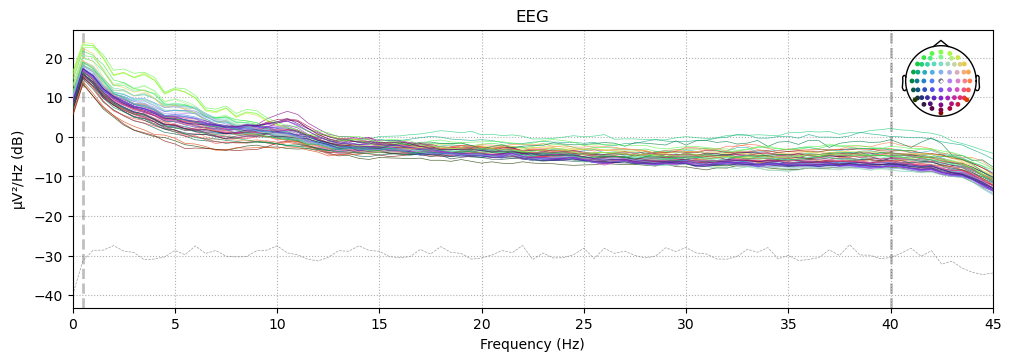

In [15]:
raw = raw.set_montage("biosemi64", on_missing="ignore")

raw.compute_psd(fmax=45).plot(picks="eeg")

## 2.2. Implementando modelo ICA

Ahora implementaremos un modelo estadístico para identificar estadísticamente a los movimientos oculares.


In [16]:
ica = ICA(n_components=16, max_iter="auto", random_state=97)
ica.fit(raw, reject_by_annotation=True)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 29559 of 535552 (5.52%) samples, retaining 505993 (94.48%) samples.


Selecting by number: 16 components
Fitting ICA took 37.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,38 iterations on raw data (505993 samples)
ICA components,16
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=21, n_times=535552
    Range : 0 ... 535551 =      0.000 ...   522.999 secs
Ready.


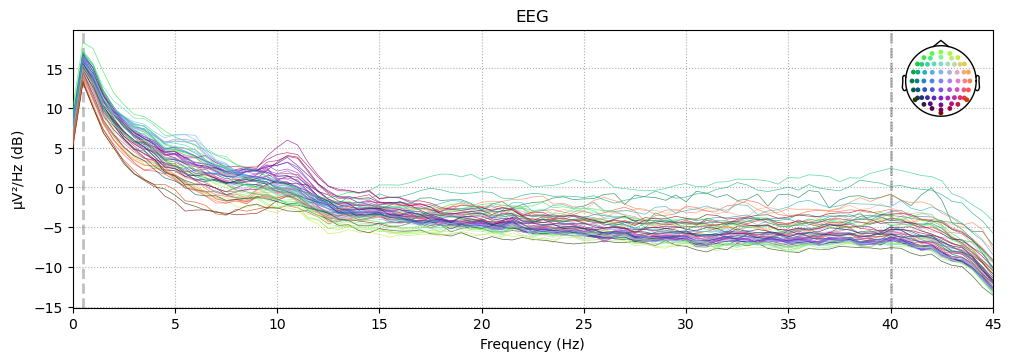

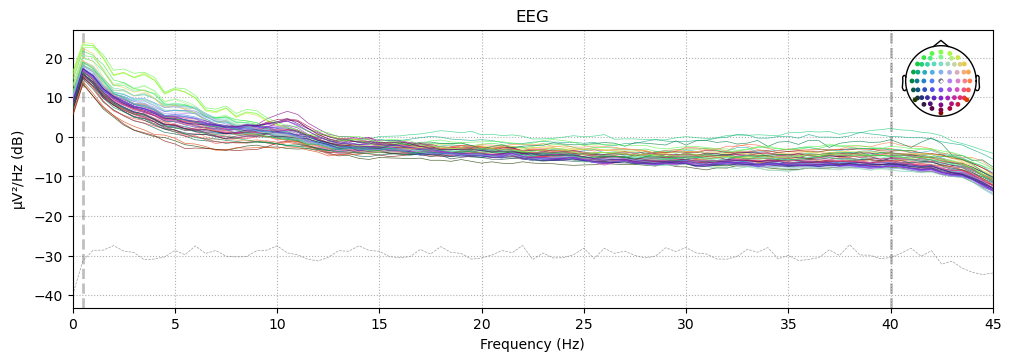

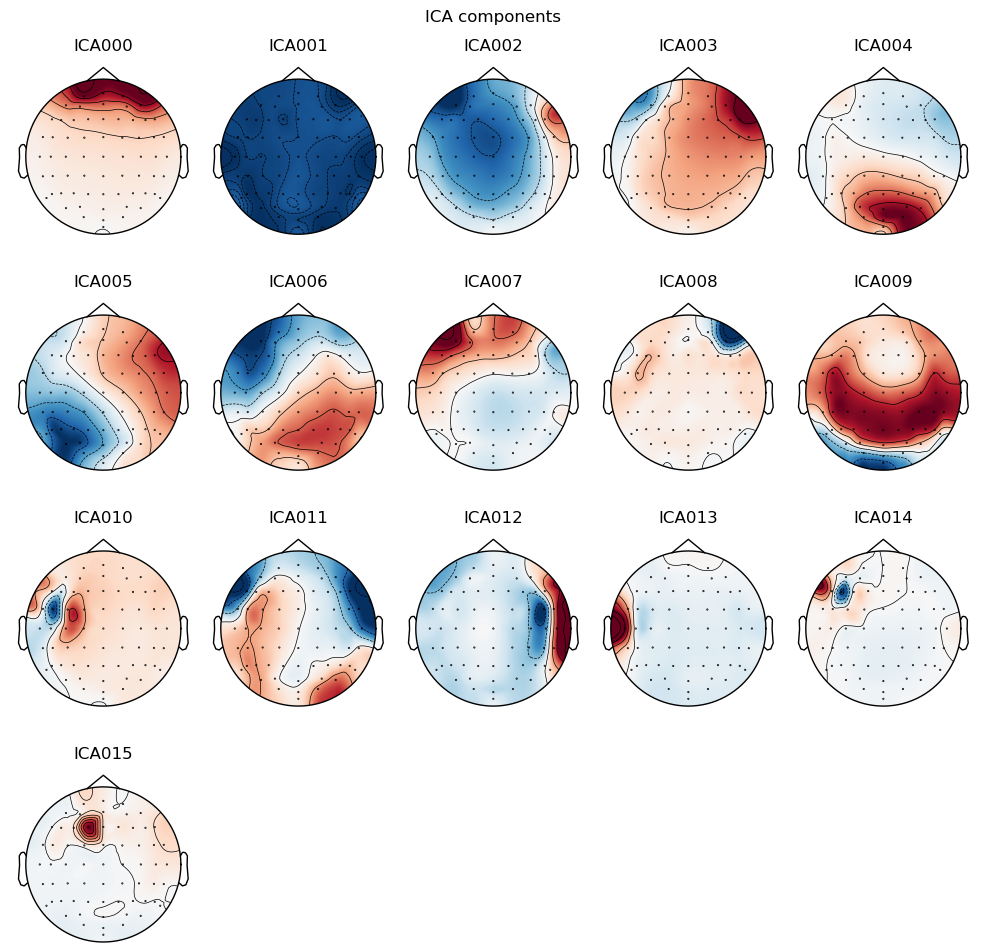

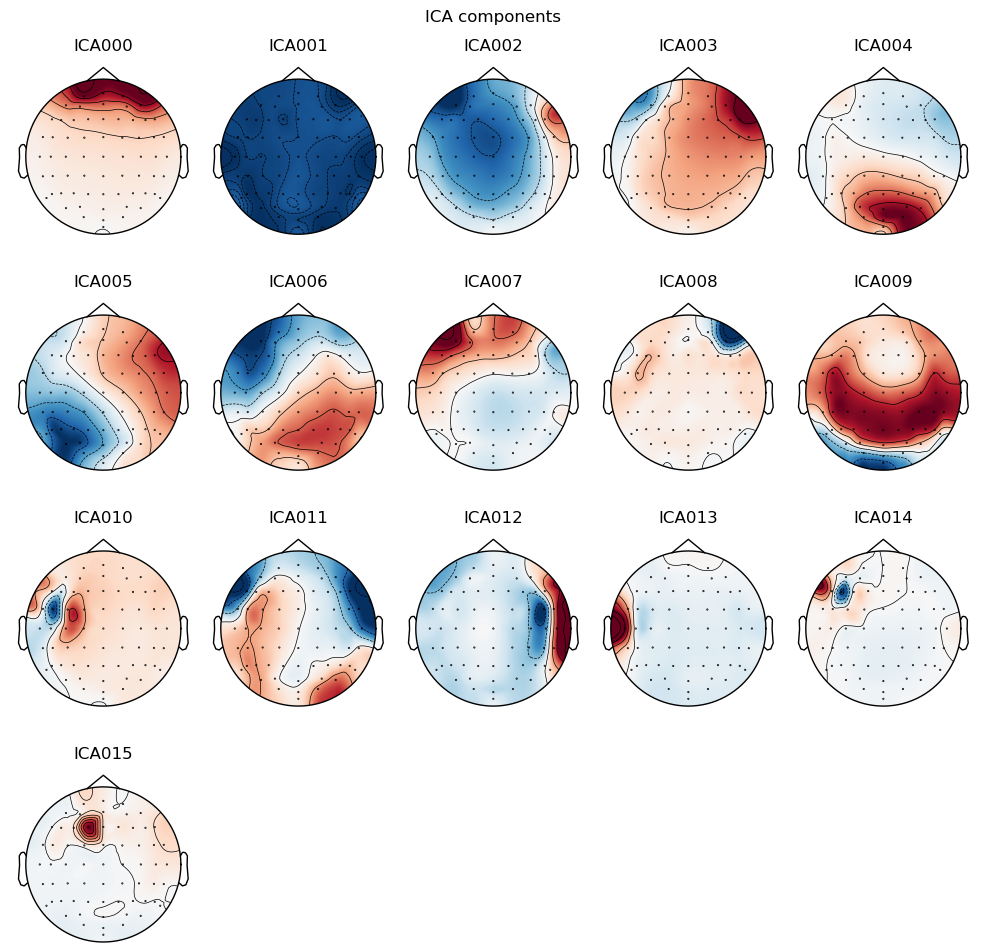

In [17]:
#raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)


ica.plot_components()

In [18]:
explained_var_ratio = ica.get_explained_variance_ratio(
    raw, components=[0,3,8], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by selected component(s): "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by selected component(s): 52%


Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


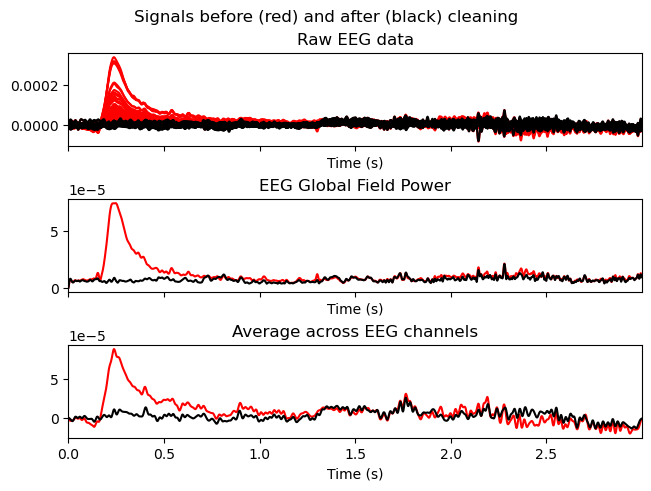

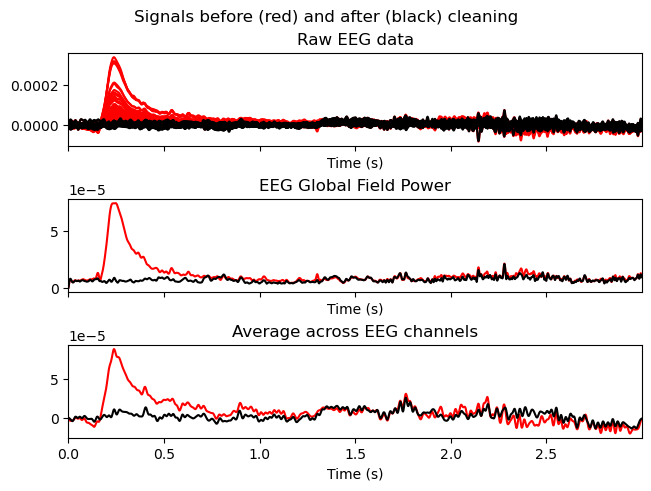

In [19]:
# blinks
ica.plot_overlay(raw, exclude=[0,3, 8])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated


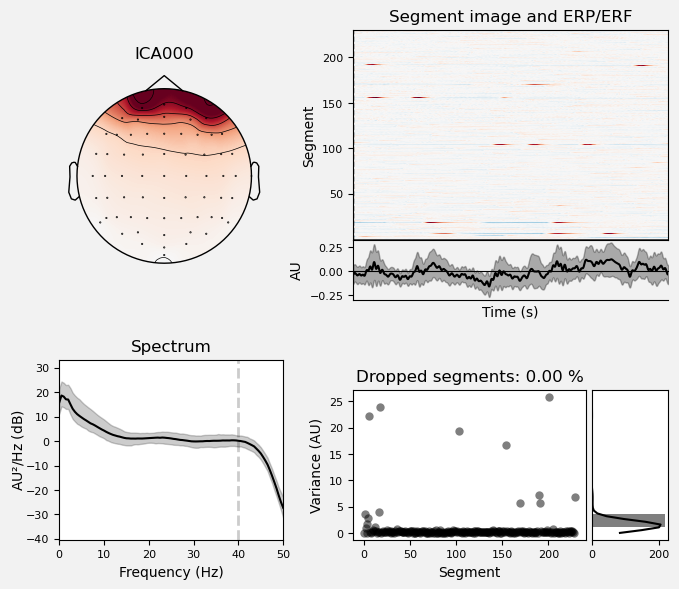

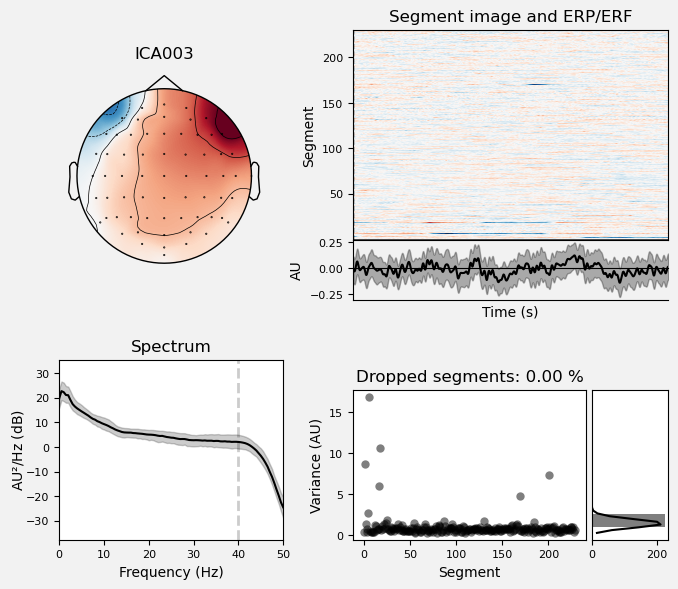

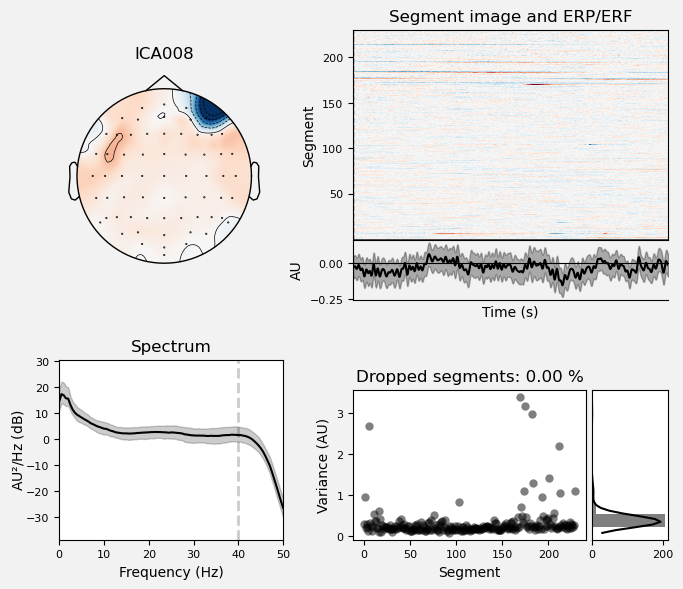

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [20]:
ica.plot_properties(raw, picks=[0,3,8])

In [21]:
ica.exclude = [0,3,8]


ica_raw = raw.copy()
ica.apply(ica_raw)



Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


<Raw | SAAV0010_TOL_REF_FILT_ANNOT.fif, 73 x 535552 (523.0 s), ~298.4 MB, data loaded>

## 2.1. Inspección posterior

Volvemos a graficar el espectro. Ahora para ver las diferencias con el anterior

Setting 29559 of 535552 (5.52%) samples to NaN, retaining 505993 (94.48%) samples.


Effective window size : 2.000 (s)


c:\Users\slipina\AppData\Local\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


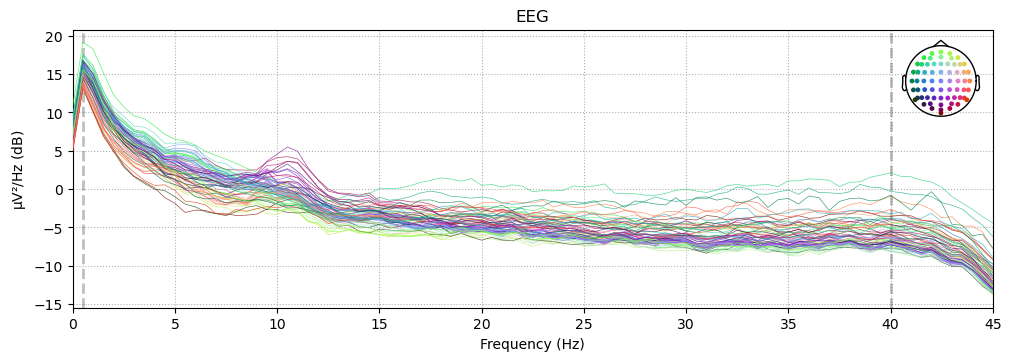

In [22]:
ica_raw.compute_psd(fmax=45, reject_by_annotation=True).plot(picks="data", exclude="bads")

# 4. Guardar datos limpios

In [23]:
ica_raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT_ICA.fif"), overwrite=True)


Overwriting existing file.
Writing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0010_TOL_REF_FILT_ANNOT_ICA.fif


C:\Users\slipina\AppData\Local\Temp\ipykernel_11980\1030269301.py:1: RuntimeWarning: This filename (e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0010_TOL_REF_FILT_ANNOT_ICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ica_raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_ANNOT_ICA.fif"), overwrite=True)


Closing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0010_TOL_REF_FILT_ANNOT_ICA.fif
[done]
